In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
import lightgbm as lgb
import optuna

In [10]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [21]:
df_train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [ ]:
df_train.columns

Index(['id', 'Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous'],
      dtype='object')

In [16]:
df_train.isnull().sum()

id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64

In [17]:
df_test.isnull().sum()

id             0
Temparature    0
Humidity       0
Moisture       0
Soil Type      0
Crop Type      0
Nitrogen       0
Potassium      0
Phosphorous    0
dtype: int64

In [20]:
print(df_test.shape,
df_train.shape)

(250000, 9) (750000, 10)


In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB


In [25]:
numerical_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']

In [26]:
df_train[numerical_cols].describe()

,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


In [27]:
df_train['Soil Type'].value_counts()

Soil Type
Sandy     156710
Black     150956
Clayey    148382
Red       148102
Loamy     145850
Name: count, dtype: int64

In [28]:
df_train['Crop Type'].value_counts()

Crop Type
Paddy          85754
Pulses         78180
Cotton         69171
Tobacco        68000
Wheat          66628
Millets        65291
Barley         65045
Sugarcane      64269
Oil seeds      64184
Maize          62569
Ground Nuts    60909
Name: count, dtype: int64

In [29]:
df_train['Fertilizer Name'].value_counts()

Fertilizer Name
14-35-14    114436
10-26-26    113887
17-17-17    112453
28-28       111158
20-20       110889
DAP          94860
Urea         92317
Name: count, dtype: int64

In [40]:
def plot(df):    
    _, axes = plt.subplots(2, 3, figsize=(18,12))

    df['Fertilizer Name'].value_counts().plot(kind='bar', ax=axes[0,0])
    axes[0,0].set_title('Fertilizer Distribution')
    axes[0,0].tick_params(axis='x', rotation=45)

    df['Soil Type'].value_counts().plot(kind='bar', ax=axes[0,1])
    axes[0,0].set_title('Soil Type Distribution')
    axes[0,0].tick_params(axis='x', rotation=45)

    df['Crop Type'].value_counts().plot(kind='bar', ax=axes[0,2])
    axes[0,0].set_title('Crop Type Distribution')
    axes[0,0].tick_params(axis='x', rotation=45)

    npk_cols = ['Nitrogen', 'Potassium', 'Phosphorous']
    corr_matrix = df[npk_cols].corr()
    sns.heatmap(corr_matrix, annot=True, ax=axes[1,0])
    axes[1,0].set_title('NPK Correlation Matrix')

    axes[1,1].scatter(df['Temparature'], df['Humidity'], alpha=0.1)
    axes[1,1].set_xlabel('Temperature')
    axes[1,1].set_ylabel('Humidity')
    axes[1,1].set_title('Temperature vs Humidity')
    
    df['Moisture'].hist(bins=50, ax=axes[1,2])
    axes[1,2].set_title('Moisture Distribution')
    axes[1,2].set_xlabel('Moisture')
    
    plt.tight_layout()
    plt.show()


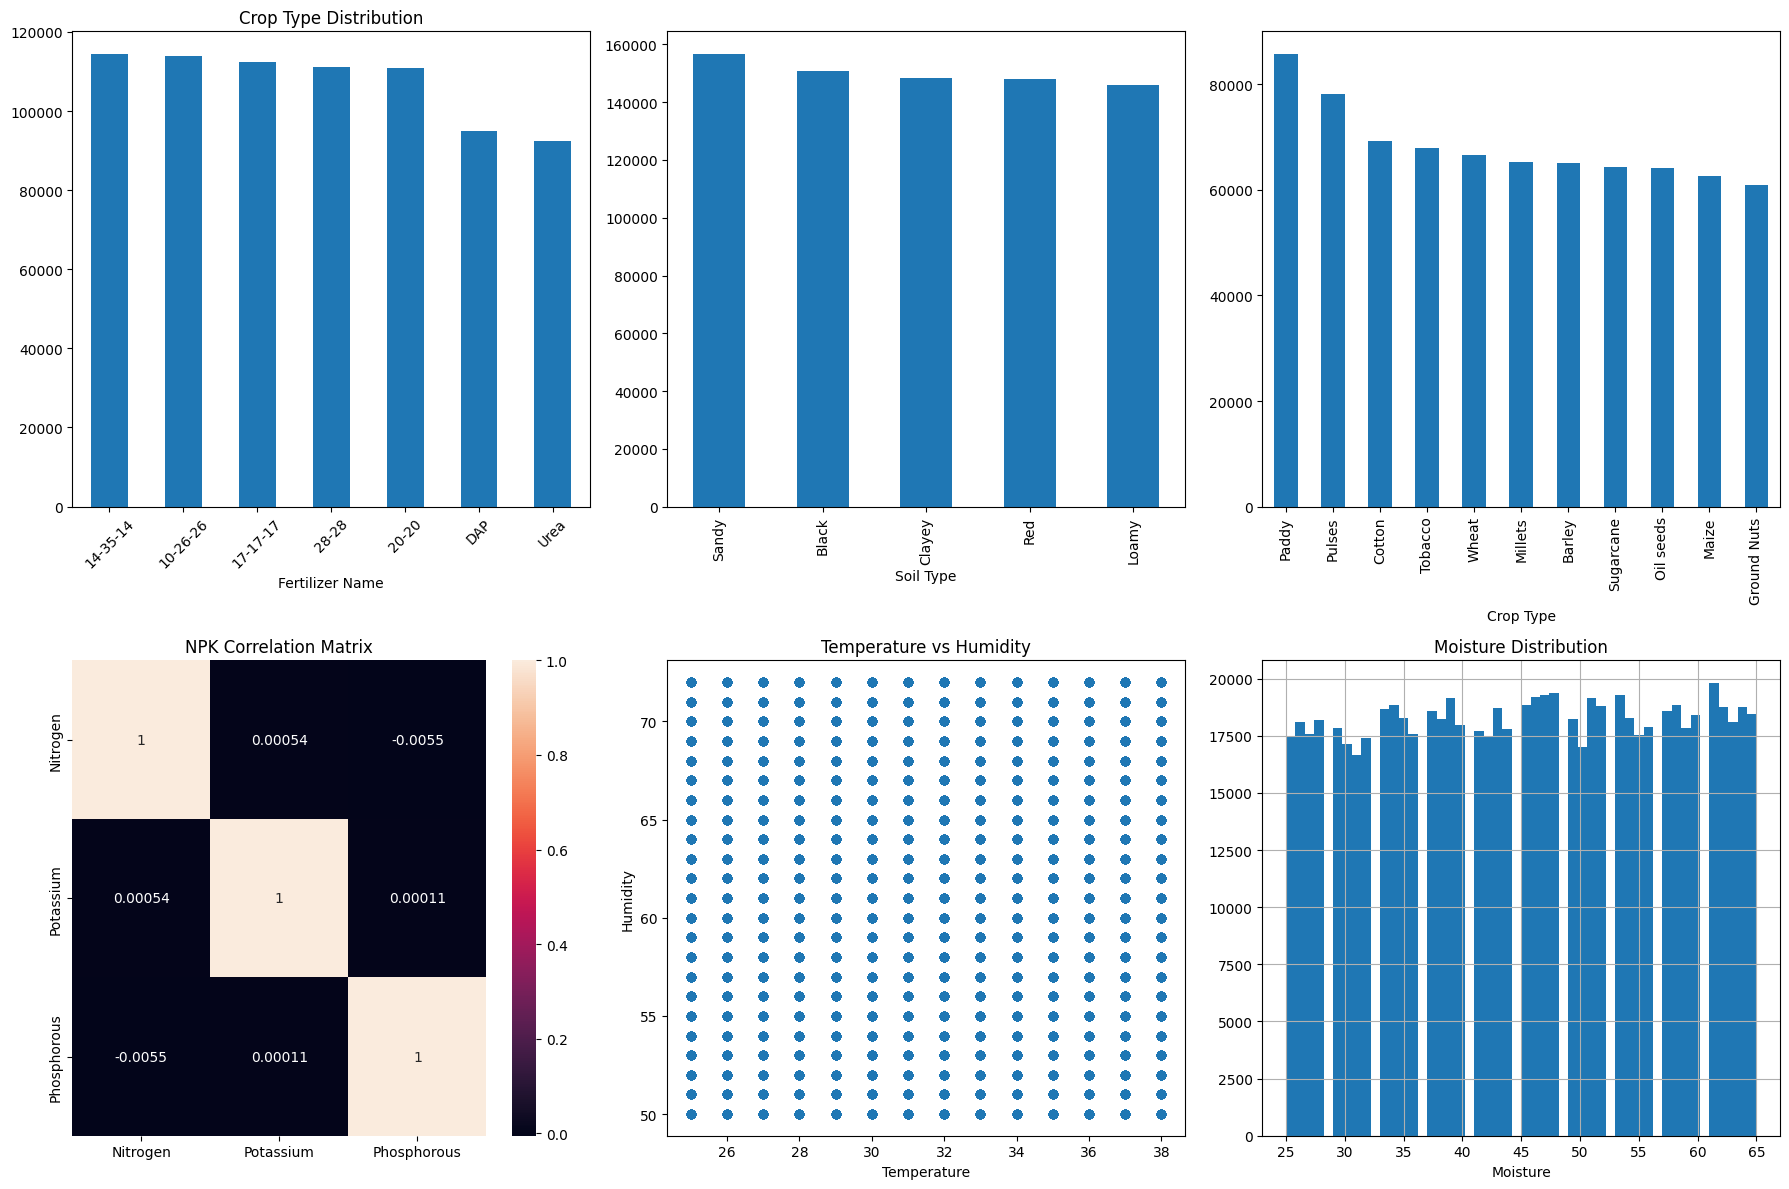

In [41]:
plot(df_train)

In [46]:
def feature_process(df):
    df['NPK_sum'] = df['Nitrogen'] + df['Potassium'] + df['Phosphorous']
    df['N_ratio'] = df['Nitrogen'] / (df['NPK_sum'] + 1e-8)
    df['P_ratio'] = df['Phosphorous'] / (df['NPK_sum'] + 1e-8)
    df['K_ratio'] = df['Potassium'] / (df['NPK_sum'] + 1e-8)
    
    df['NP_ratio'] = df['Nitrogen'] / (df['Phosphorous'] + 1e-8)
    df['NK_ratio'] = df['Nitrogen'] / (df['Potassium'] + 1e-8)
    df['PK_ratio'] = df['Phosphorous'] / (df['Potassium'] + 1e-8)
    
    df['Temp_Humidity_interaction'] = df['Temparature'] * df['Humidity']
    df['Temp_Moisture_interaction'] = df['Temparature'] * df['Moisture']
    df['Humidity_Moisture_interaction'] = df['Humidity'] * df['Moisture']
    
    df['Temp_binned'] = pd.cut(df['Temparature'], bins=10, labels=False)
    df['Humidity_binned'] = pd.cut(df['Humidity'], bins=10, labels=False)
    df['Moisture_binned'] = pd.cut(df['Moisture'], bins=10, labels=False)
    
    le_soil = LabelEncoder()
    le_crop = LabelEncoder()
    
    df['Soil_Type_encoded'] = le_soil.fit_transform(df['Soil Type'])
    df['Crop_Type_encoded'] = le_crop.fit_transform(df['Crop Type'])
    
    df['Soil_Crop_interaction'] = df['Soil_Type_encoded'] * 100 + df['Crop_Type_encoded']
    
    df['N_adequacy'] = np.abs(df['Nitrogen'] - 50) / 50 
    df['P_adequacy'] = np.abs(df['Phosphorous'] - 50) / 50
    df['K_adequacy'] = np.abs(df['Potassium'] - 50) / 50
    
    return df
    

In [47]:
df_train = feature_process(df_train)
df_test = feature_process(df_test)

In [52]:
df_train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name,...,Humidity_Moisture_interaction,Temp_binned,Humidity_binned,Moisture_binned,Soil_Type_encoded,Crop_Type_encoded,Soil_Crop_interaction,N_adequacy,P_adequacy,K_adequacy
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28,...,2520,9,9,2,1,8,108,0.28,0.90,0.92
1,1,27,69,65,Sandy,Millets,30,6,18,28-28,...,4485,1,8,9,4,4,404,0.40,0.64,0.88
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17,...,2016,3,5,1,4,4,404,0.52,0.68,0.76
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26,...,3348,7,5,7,4,0,400,0.22,0.92,0.76
4,4,35,58,43,Red,Paddy,37,2,16,DAP,...,2494,7,3,4,3,6,306,0.26,0.68,0.96


In [54]:
def apk(actual,predicted,k=3):
    if len(predicted) > k:
        predicted = predicted[:k]
    
    score = 0.0
    num_hits = 0.0
    
    for i, p in enumerate(predicted):
        if p == actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    
    return score

In [55]:
def mapk(y_true,y_pred,k=3):
    top_k_preds = []
    for probs in y_pred:
        top_k_idx = np.argsort(probs)[::-1][:k]
        top_k_preds.append(top_k_idx)
        
    return np.mean([apk(actual, predicted, k) for actual, predicted in zip(y_true, top_k_preds)])

In [56]:
def map3_lgb_eval(y_pred, y_true):
    """Custom MAP@3 evaluation function for LightGBM"""
    y_true = y_true.get_label().astype(int)
    y_pred = y_pred.reshape(len(y_true), -1)
    return 'map3', mapk(y_true, y_pred, k=3), True

def map3_xgb_eval(y_pred, y_true):
    """Custom MAP@3 evaluation function for XGBoost"""
    y_true = y_true.get_label().astype(int)
    y_pred = y_pred.reshape(len(y_true), -1)
    return 'map3', mapk(y_true, y_pred, k=3)

In [57]:
def data_preperation(df_train, df_test):
    feature_cols = [col for col in df_train.columns if col not in ['id', 'Fertilizer Name', 'Soil Type', 'Crop Type']]
    
    X = df_train[feature_cols]
    y = df_train['Fertilizer Name']
    
    encoder_target = LabelEncoder()
    y_encoded = encoder_target.fit_transform(y)
    
    X_test = df_test[feature_cols]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.fit_transform(X_test)
    
    print(f"Feature columns ({len(feature_cols)}): {feature_cols}")
    print(f"Target classes: {encoder_target.classes_}")
    
    return X, X_scaled, y_encoded, X_test, X_test_scaled, encoder_target, feature_cols, scaler

In [58]:
X, X_scaled, y_encoded, X_test, X_test_scaled, le_target, feature_cols, scaler = data_preperation(df_train, df_test)

Feature columns (25): ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous', 'NPK_sum', 'N_ratio', 'P_ratio', 'K_ratio', 'NP_ratio', 'NK_ratio', 'PK_ratio', 'Temp_Humidity_interaction', 'Temp_Moisture_interaction', 'Humidity_Moisture_interaction', 'Temp_binned', 'Humidity_binned', 'Moisture_binned', 'Soil_Type_encoded', 'Crop_Type_encoded', 'Soil_Crop_interaction', 'N_adequacy', 'P_adequacy', 'K_adequacy']
Target classes: ['10-26-26' '14-35-14' '17-17-17' '20-20' '28-28' 'DAP' 'Urea']


In [60]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [67]:
xgb_params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'mlogloss',
    'random_state': 42,
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbosity': 0
}

In [69]:
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=True)

[0]	validation_0-mlogloss:1.94507
[1]	validation_0-mlogloss:1.94432
[2]	validation_0-mlogloss:1.94364
[3]	validation_0-mlogloss:1.94299
[4]	validation_0-mlogloss:1.94241
[5]	validation_0-mlogloss:1.94187
[6]	validation_0-mlogloss:1.94140
[7]	validation_0-mlogloss:1.94096
[8]	validation_0-mlogloss:1.94056
[9]	validation_0-mlogloss:1.94018
[10]	validation_0-mlogloss:1.93981
[11]	validation_0-mlogloss:1.93945
[12]	validation_0-mlogloss:1.93908
[13]	validation_0-mlogloss:1.93878
[14]	validation_0-mlogloss:1.93847
[15]	validation_0-mlogloss:1.93820
[16]	validation_0-mlogloss:1.93790
[17]	validation_0-mlogloss:1.93765
[18]	validation_0-mlogloss:1.93744
[19]	validation_0-mlogloss:1.93722
[20]	validation_0-mlogloss:1.93702
[21]	validation_0-mlogloss:1.93682
[22]	validation_0-mlogloss:1.93660
[23]	validation_0-mlogloss:1.93638
[24]	validation_0-mlogloss:1.93616
[25]	validation_0-mlogloss:1.93599
[26]	validation_0-mlogloss:1.93580
[27]	validation_0-mlogloss:1.93560
[28]	validation_0-mlogloss:1.9

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [72]:
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),
    'metric': 'multi_logloss',
    'random_state': 42,
    'n_estimators': 1000,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8
    }

In [73]:
lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[280]	valid_0's multi_logloss: 1.92617


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,1000
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [74]:
xgb_pred_proba = xgb_model.predict_proba(X_val)
lgb_pred_proba = lgb_model.predict_proba(X_val)

xgb_map3 = mapk(y_val, xgb_pred_proba, k=3)
lgb_map3 = mapk(y_val, lgb_pred_proba, k=3)

print(f"XGBoost MAP@3: {xgb_map3:.4f}")
print(f"LightGBM MAP@3: {lgb_map3:.4f}")

/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


XGBoost MAP@3: 0.3240
LightGBM MAP@3: 0.3203


In [84]:
def objective_optimizer_xgb(trial):
    xgb_optimized_params = {
            'objective': 'multi:softprob',
            'num_class': len(np.unique(y_train)),
            'eval_metric': 'mlogloss',
            'random_state': 42,
            'verbosity': 1,
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    }
    
    xgb_model = xgb.XGBClassifier(**xgb_optimized_params)
    xgb_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
    xgb_pred_proba = xgb_model.predict_proba(X_val)
    xgb_map3_score = mapk(y_val, xgb_pred_proba, k=3)

        
    return xgb_map3_score

In [89]:
def objective_optimizer_lgb(trial):  
    lgb_optimized_params = {
            'objective': 'multiclass',
            'num_class': len(np.unique(y_train)),
            'metric': 'multi_logloss',
            'random_state': 42,
            'verbosity': -1,
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    
    lgb_model = lgb.LGBMClassifier(**lgb_optimized_params)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    lgb_pred_proba = lgb_model.predict_proba(X_val)
    lgb_map3_score = mapk(y_val, lgb_pred_proba, k=3)

        
    return lgb_map3_score

In [87]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_optimizer_xgb, n_trials = 10, show_progress_bar=True)
print(f"Best XGBoost MAP@3: {study_xgb.best_value:.4f}")
print(f"Best XGBoost params: {study_xgb.best_params}")

[I 2025-06-12 16:42:11,966] A new study created in memory with name: no-name-0d5fdbf3-af46-4e77-8d1a-a51ff9a49c90
Best trial: 0. Best value: 0.322496:  10%|█         | 1/10 [04:07<37:09, 247.69s/it]

[I 2025-06-12 16:46:19,667] Trial 0 finished with value: 0.3224955555555556 and parameters: {'n_estimators': 1794, 'learning_rate': 0.29699018832955887, 'max_depth': 3, 'subsample': 0.6456879213897447, 'colsample_bytree': 0.9906128071092862, 'reg_alpha': 4.512580072958926, 'reg_lambda': 3.8977977877923586}. Best is trial 0 with value: 0.3224955555555556.


Best trial: 1. Best value: 0.324066:  20%|██        | 2/10 [08:52<35:58, 269.81s/it]

[I 2025-06-12 16:51:04,974] Trial 1 finished with value: 0.32406555555555555 and parameters: {'n_estimators': 846, 'learning_rate': 0.019835596977254864, 'max_depth': 10, 'subsample': 0.6890088999159142, 'colsample_bytree': 0.8982191216398369, 'reg_alpha': 2.2421902286246387, 'reg_lambda': 8.606821824640202}. Best is trial 1 with value: 0.32406555555555555.


Best trial: 2. Best value: 0.327073:  30%|███       | 3/10 [11:08<24:18, 208.34s/it]

[I 2025-06-12 16:53:20,136] Trial 2 finished with value: 0.3270733333333333 and parameters: {'n_estimators': 911, 'learning_rate': 0.15483350347900385, 'max_depth': 5, 'subsample': 0.9855170610318763, 'colsample_bytree': 0.7044743268379241, 'reg_alpha': 6.513419779371037, 'reg_lambda': 5.910643813426098}. Best is trial 2 with value: 0.3270733333333333.


Best trial: 2. Best value: 0.327073:  40%|████      | 4/10 [13:37<18:29, 184.87s/it]

[I 2025-06-12 16:55:49,057] Trial 3 finished with value: 0.3238533333333334 and parameters: {'n_estimators': 1193, 'learning_rate': 0.28255867014324, 'max_depth': 5, 'subsample': 0.9871282451917229, 'colsample_bytree': 0.8671513060205125, 'reg_alpha': 6.074291135421852, 'reg_lambda': 3.4885929977894103}. Best is trial 2 with value: 0.3270733333333333.


Best trial: 2. Best value: 0.327073:  50%|█████     | 5/10 [15:39<13:32, 162.48s/it]

[I 2025-06-12 16:57:51,822] Trial 4 finished with value: 0.3249477777777778 and parameters: {'n_estimators': 1078, 'learning_rate': 0.217026086549759, 'max_depth': 4, 'subsample': 0.8534513698535217, 'colsample_bytree': 0.8057197809563412, 'reg_alpha': 4.140535736610128, 'reg_lambda': 1.5154227547592758}. Best is trial 2 with value: 0.3270733333333333.


Best trial: 2. Best value: 0.327073:  60%|██████    | 6/10 [19:20<12:08, 182.18s/it]

[I 2025-06-12 17:01:32,233] Trial 5 finished with value: 0.3186166666666667 and parameters: {'n_estimators': 1252, 'learning_rate': 0.1491682953470663, 'max_depth': 7, 'subsample': 0.7465620225187283, 'colsample_bytree': 0.8752002117122561, 'reg_alpha': 2.210483253031775, 'reg_lambda': 5.8967086310989565}. Best is trial 2 with value: 0.3270733333333333.


Best trial: 2. Best value: 0.327073:  70%|███████   | 7/10 [27:55<14:33, 291.15s/it]

[I 2025-06-12 17:10:07,737] Trial 6 finished with value: 0.3025277777777778 and parameters: {'n_estimators': 1707, 'learning_rate': 0.2327625517976176, 'max_depth': 10, 'subsample': 0.8407882388528158, 'colsample_bytree': 0.8450260722352583, 'reg_alpha': 0.6938602131280958, 'reg_lambda': 4.837536104700403}. Best is trial 2 with value: 0.3270733333333333.


Best trial: 2. Best value: 0.327073:  80%|████████  | 8/10 [29:20<07:31, 225.59s/it]

[I 2025-06-12 17:11:32,981] Trial 7 finished with value: 0.321811111111111 and parameters: {'n_estimators': 566, 'learning_rate': 0.27095177795521497, 'max_depth': 6, 'subsample': 0.862051837569902, 'colsample_bytree': 0.8131951452352812, 'reg_alpha': 0.9834108801815244, 'reg_lambda': 9.016778870472809}. Best is trial 2 with value: 0.3270733333333333.


Best trial: 2. Best value: 0.327073:  90%|█████████ | 9/10 [31:32<03:16, 196.28s/it]

[I 2025-06-12 17:13:44,811] Trial 8 finished with value: 0.3164333333333333 and parameters: {'n_estimators': 508, 'learning_rate': 0.21590114651376538, 'max_depth': 9, 'subsample': 0.8712673946717007, 'colsample_bytree': 0.7769196161536951, 'reg_alpha': 5.488388864428835, 'reg_lambda': 0.6769259207682288}. Best is trial 2 with value: 0.3270733333333333.


Best trial: 2. Best value: 0.327073: 100%|██████████| 10/10 [36:47<00:00, 220.78s/it]

[I 2025-06-12 17:18:59,825] Trial 9 finished with value: 0.3116266666666667 and parameters: {'n_estimators': 1468, 'learning_rate': 0.19142487348405282, 'max_depth': 8, 'subsample': 0.7722440313978233, 'colsample_bytree': 0.8996797372894774, 'reg_alpha': 2.9413825562486706, 'reg_lambda': 6.245505827658598}. Best is trial 2 with value: 0.3270733333333333.
Best XGBoost MAP@3: 0.3271
Best XGBoost params: {'n_estimators': 911, 'learning_rate': 0.15483350347900385, 'max_depth': 5, 'subsample': 0.9855170610318763, 'colsample_bytree': 0.7044743268379241, 'reg_alpha': 6.513419779371037, 'reg_lambda': 5.910643813426098}


In [91]:
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_optimizer_lgb, n_trials = 50, show_progress_bar=True)
print(f"Best XGBoost MAP@3: {study_lgb.best_value:.4f}")
print(f"Best XGBoost params: {study_lgb.best_params}")

[I 2025-06-12 17:34:31,681] A new study created in memory with name: no-name-fb1c1c56-f341-43c7-9bf5-de7a36cc40d5
  0%|          | 0/50 [00:00<?, ?it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[45]	valid_0's multi_logloss: 1.92539


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 0. Best value: 0.320813:   2%|▏         | 1/50 [00:15<12:15, 15.01s/it]

[I 2025-06-12 17:34:46,695] Trial 0 finished with value: 0.32081333333333334 and parameters: {'n_estimators': 1731, 'learning_rate': 0.2654924668993276, 'num_leaves': 88, 'subsample': 0.6213646166285438, 'colsample_bytree': 0.6172634149638534, 'reg_alpha': 1.9545363511381286, 'reg_lambda': 9.396646303587868, 'min_child_samples': 80}. Best is trial 0 with value: 0.32081333333333334.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[106]	valid_0's multi_logloss: 1.92365


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 1. Best value: 0.322863:   4%|▍         | 2/50 [00:41<17:11, 21.49s/it]

[I 2025-06-12 17:35:12,713] Trial 1 finished with value: 0.3228633333333334 and parameters: {'n_estimators': 630, 'learning_rate': 0.19047218499175406, 'num_leaves': 54, 'subsample': 0.8140404833188187, 'colsample_bytree': 0.8457474514784631, 'reg_alpha': 7.125870651555795, 'reg_lambda': 2.7048586950850497, 'min_child_samples': 50}. Best is trial 1 with value: 0.3228633333333334.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's multi_logloss: 1.92387


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 1. Best value: 0.322863:   6%|▌         | 3/50 [00:57<15:12, 19.42s/it]

[I 2025-06-12 17:35:29,670] Trial 2 finished with value: 0.3223622222222222 and parameters: {'n_estimators': 1311, 'learning_rate': 0.29018745835156723, 'num_leaves': 37, 'subsample': 0.8676630533845422, 'colsample_bytree': 0.7140546509516257, 'reg_alpha': 9.334216879024172, 'reg_lambda': 1.188669586129446, 'min_child_samples': 99}. Best is trial 1 with value: 0.3228633333333334.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 1.92427


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 1. Best value: 0.322863:   8%|▊         | 4/50 [01:20<15:55, 20.78s/it]

[I 2025-06-12 17:35:52,521] Trial 3 finished with value: 0.3217533333333333 and parameters: {'n_estimators': 1193, 'learning_rate': 0.1790973887404836, 'num_leaves': 93, 'subsample': 0.7593292618595131, 'colsample_bytree': 0.9777165073943515, 'reg_alpha': 5.926978795163009, 'reg_lambda': 2.293267059062659, 'min_child_samples': 78}. Best is trial 1 with value: 0.3228633333333334.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's multi_logloss: 1.92551


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 1. Best value: 0.322863:  10%|█         | 5/50 [01:42<15:42, 20.95s/it]

[I 2025-06-12 17:36:13,801] Trial 4 finished with value: 0.3212499999999999 and parameters: {'n_estimators': 1608, 'learning_rate': 0.2829303531470623, 'num_leaves': 32, 'subsample': 0.654673069105255, 'colsample_bytree': 0.9690605180386194, 'reg_alpha': 3.7557350531591513, 'reg_lambda': 6.221021177129168, 'min_child_samples': 84}. Best is trial 1 with value: 0.3228633333333334.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[108]	valid_0's multi_logloss: 1.92327


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.323563:  12%|█▏        | 6/50 [02:14<18:11, 24.80s/it]

[I 2025-06-12 17:36:46,056] Trial 5 finished with value: 0.3235633333333333 and parameters: {'n_estimators': 1393, 'learning_rate': 0.14257945633353972, 'num_leaves': 80, 'subsample': 0.7046541978849946, 'colsample_bytree': 0.9660289898851615, 'reg_alpha': 6.293284467272603, 'reg_lambda': 5.8702383686628234, 'min_child_samples': 48}. Best is trial 5 with value: 0.3235633333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 1.92409


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.323563:  14%|█▍        | 7/50 [02:39<17:50, 24.89s/it]

[I 2025-06-12 17:37:11,148] Trial 6 finished with value: 0.32135111111111114 and parameters: {'n_estimators': 843, 'learning_rate': 0.1899495816359169, 'num_leaves': 88, 'subsample': 0.9865348286223499, 'colsample_bytree': 0.7283016012698671, 'reg_alpha': 6.338144742229618, 'reg_lambda': 0.9286770474509953, 'min_child_samples': 64}. Best is trial 5 with value: 0.3235633333333333.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[741]	valid_0's multi_logloss: 1.924


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.323563:  16%|█▌        | 8/50 [05:09<45:19, 64.76s/it]

[I 2025-06-12 17:39:41,253] Trial 7 finished with value: 0.3233011111111111 and parameters: {'n_estimators': 741, 'learning_rate': 0.022817166422965076, 'num_leaves': 35, 'subsample': 0.8288891978375488, 'colsample_bytree': 0.9263570977666412, 'reg_alpha': 3.3150900719599696, 'reg_lambda': 7.0223200908010694, 'min_child_samples': 87}. Best is trial 5 with value: 0.3235633333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[88]	valid_0's multi_logloss: 1.92549


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.323563:  18%|█▊        | 9/50 [05:40<36:58, 54.11s/it]

[I 2025-06-12 17:40:11,950] Trial 8 finished with value: 0.3200944444444444 and parameters: {'n_estimators': 977, 'learning_rate': 0.12253822871005508, 'num_leaves': 93, 'subsample': 0.8096979329174006, 'colsample_bytree': 0.7601896246564945, 'reg_alpha': 1.0197031789570454, 'reg_lambda': 1.1097953099792457, 'min_child_samples': 55}. Best is trial 5 with value: 0.3235633333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[847]	valid_0's multi_logloss: 1.92144


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 9. Best value: 0.326203:  20%|██        | 10/50 [08:22<58:17, 87.43s/it]

[I 2025-06-12 17:42:53,965] Trial 9 finished with value: 0.3262033333333333 and parameters: {'n_estimators': 1513, 'learning_rate': 0.05678948953713481, 'num_leaves': 29, 'subsample': 0.672783833442737, 'colsample_bytree': 0.994427583215988, 'reg_alpha': 7.682235690485645, 'reg_lambda': 5.454604351026992, 'min_child_samples': 43}. Best is trial 9 with value: 0.3262033333333333.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1975]	valid_0's multi_logloss: 1.92138


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 9. Best value: 0.326203:  22%|██▏       | 11/50 [13:50<1:44:40, 161.03s/it]

[I 2025-06-12 17:48:21,896] Trial 10 finished with value: 0.3259277777777778 and parameters: {'n_estimators': 1975, 'learning_rate': 0.027980858708960617, 'num_leaves': 21, 'subsample': 0.7116710252568565, 'colsample_bytree': 0.8545082206196007, 'reg_alpha': 9.763215144512925, 'reg_lambda': 4.41224611867821, 'min_child_samples': 11}. Best is trial 9 with value: 0.3262033333333333.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1991]	valid_0's multi_logloss: 1.9225


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 9. Best value: 0.326203:  24%|██▍       | 12/50 [19:31<2:16:44, 215.90s/it]

[I 2025-06-12 17:54:03,297] Trial 11 finished with value: 0.3251644444444445 and parameters: {'n_estimators': 1991, 'learning_rate': 0.018555458413000603, 'num_leaves': 20, 'subsample': 0.7161756307135089, 'colsample_bytree': 0.8726204188019785, 'reg_alpha': 9.916316197804328, 'reg_lambda': 4.0707989785687655, 'min_child_samples': 12}. Best is trial 9 with value: 0.3262033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[459]	valid_0's multi_logloss: 1.9214


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 12. Best value: 0.32622:  26%|██▌       | 13/50 [21:07<1:50:43, 179.54s/it]

[I 2025-06-12 17:55:39,181] Trial 12 finished with value: 0.32622 and parameters: {'n_estimators': 1977, 'learning_rate': 0.07593999541430654, 'num_leaves': 54, 'subsample': 0.6787614633681819, 'colsample_bytree': 0.8722875560481861, 'reg_alpha': 8.180935637848364, 'reg_lambda': 4.4227708304650015, 'min_child_samples': 6}. Best is trial 12 with value: 0.32622.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[365]	valid_0's multi_logloss: 1.92129


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  28%|██▊       | 14/50 [22:39<1:31:55, 153.20s/it]

[I 2025-06-12 17:57:11,481] Trial 13 finished with value: 0.3265033333333333 and parameters: {'n_estimators': 1665, 'learning_rate': 0.07722221815148156, 'num_leaves': 59, 'subsample': 0.6467253545992631, 'colsample_bytree': 0.9019776463024597, 'reg_alpha': 7.480321453693046, 'reg_lambda': 8.187040129303698, 'min_child_samples': 30}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[257]	valid_0's multi_logloss: 1.92196


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  30%|███       | 15/50 [23:42<1:13:29, 125.98s/it]

[I 2025-06-12 17:58:14,404] Trial 14 finished with value: 0.3250733333333333 and parameters: {'n_estimators': 1831, 'learning_rate': 0.08915579190111425, 'num_leaves': 63, 'subsample': 0.6076933468361265, 'colsample_bytree': 0.9117920772183109, 'reg_alpha': 8.077515922905848, 'reg_lambda': 8.319146288428428, 'min_child_samples': 30}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[275]	valid_0's multi_logloss: 1.9215


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  32%|███▏      | 16/50 [24:47<1:00:56, 107.53s/it]

[I 2025-06-12 17:59:19,085] Trial 15 finished with value: 0.32620666666666664 and parameters: {'n_estimators': 1751, 'learning_rate': 0.09123388313526767, 'num_leaves': 54, 'subsample': 0.9003529553936297, 'colsample_bytree': 0.7974430507922695, 'reg_alpha': 8.361770474874177, 'reg_lambda': 7.645753788963962, 'min_child_samples': 26}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's multi_logloss: 1.92198


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  34%|███▍      | 17/50 [25:52<52:11, 94.89s/it]   

[I 2025-06-12 18:00:24,586] Trial 16 finished with value: 0.32488333333333336 and parameters: {'n_estimators': 1579, 'learning_rate': 0.07694634781289961, 'num_leaves': 67, 'subsample': 0.7560487882949597, 'colsample_bytree': 0.9057158926091987, 'reg_alpha': 4.709173034734612, 'reg_lambda': 9.623003699206352, 'min_child_samples': 27}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[296]	valid_0's multi_logloss: 1.92183


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  36%|███▌      | 18/50 [26:56<45:30, 85.34s/it]

[I 2025-06-12 18:01:27,693] Trial 17 finished with value: 0.32521666666666665 and parameters: {'n_estimators': 1104, 'learning_rate': 0.12215992984096798, 'num_leaves': 45, 'subsample': 0.6564018470801838, 'colsample_bytree': 0.8148346722432769, 'reg_alpha': 8.781375987612032, 'reg_lambda': 3.287966567333247, 'min_child_samples': 5}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[444]	valid_0's multi_logloss: 1.92109


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  38%|███▊      | 19/50 [28:36<46:27, 89.92s/it]

[I 2025-06-12 18:03:08,275] Trial 18 finished with value: 0.32636666666666664 and parameters: {'n_estimators': 1842, 'learning_rate': 0.05462431839588243, 'num_leaves': 73, 'subsample': 0.7386179137173545, 'colsample_bytree': 0.6457241983507986, 'reg_alpha': 4.74359640331207, 'reg_lambda': 8.571819655432982, 'min_child_samples': 18}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 1.92441


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  40%|████      | 20/50 [28:58<34:47, 69.59s/it]

[I 2025-06-12 18:03:30,460] Trial 19 finished with value: 0.3215866666666667 and parameters: {'n_estimators': 1420, 'learning_rate': 0.23012125951648457, 'num_leaves': 73, 'subsample': 0.7491960445124459, 'colsample_bytree': 0.602893275234984, 'reg_alpha': 4.893123108856769, 'reg_lambda': 8.650773521891292, 'min_child_samples': 36}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[514]	valid_0's multi_logloss: 1.92171


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 13. Best value: 0.326503:  42%|████▏     | 21/50 [30:54<40:21, 83.51s/it]

[I 2025-06-12 18:05:26,442] Trial 20 finished with value: 0.32602333333333333 and parameters: {'n_estimators': 1800, 'learning_rate': 0.04868627625439183, 'num_leaves': 75, 'subsample': 0.9210463660668049, 'colsample_bytree': 0.6747408718704295, 'reg_alpha': 3.3691240004526115, 'reg_lambda': 7.039490116079165, 'min_child_samples': 23}. Best is trial 13 with value: 0.3265033333333333.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[573]	valid_0's multi_logloss: 1.9209


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 21. Best value: 0.327247:  44%|████▍     | 22/50 [32:48<43:10, 92.52s/it]

[I 2025-06-12 18:07:19,993] Trial 21 finished with value: 0.32724666666666674 and parameters: {'n_estimators': 1897, 'learning_rate': 0.06451155635424383, 'num_leaves': 52, 'subsample': 0.6793564162615844, 'colsample_bytree': 0.6557169193028267, 'reg_alpha': 7.26556602787062, 'reg_lambda': 8.522457207865134, 'min_child_samples': 18}. Best is trial 21 with value: 0.32724666666666674.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[278]	valid_0's multi_logloss: 1.92165


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 21. Best value: 0.327247:  46%|████▌     | 23/50 [33:46<36:57, 82.11s/it]

[I 2025-06-12 18:08:17,827] Trial 22 finished with value: 0.325058888888889 and parameters: {'n_estimators': 1640, 'learning_rate': 0.10680147820764366, 'num_leaves': 48, 'subsample': 0.6431179769322241, 'colsample_bytree': 0.6442225488399916, 'reg_alpha': 6.934955851782202, 'reg_lambda': 9.928550690472123, 'min_child_samples': 15}. Best is trial 21 with value: 0.32724666666666674.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[660]	valid_0's multi_logloss: 1.92045


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 23. Best value: 0.32751:  48%|████▊     | 24/50 [36:06<43:09, 99.59s/it] 

[I 2025-06-12 18:10:38,161] Trial 23 finished with value: 0.32750999999999997 and parameters: {'n_estimators': 1847, 'learning_rate': 0.05062480856439563, 'num_leaves': 65, 'subsample': 0.7707743715331008, 'colsample_bytree': 0.6771238291605398, 'reg_alpha': 5.767701579062722, 'reg_lambda': 8.581488521185737, 'min_child_samples': 19}. Best is trial 23 with value: 0.32750999999999997.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[731]	valid_0's multi_logloss: 1.92062


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 23. Best value: 0.32751:  50%|█████     | 25/50 [38:41<48:23, 116.14s/it]

[I 2025-06-12 18:13:12,926] Trial 24 finished with value: 0.3273444444444444 and parameters: {'n_estimators': 1853, 'learning_rate': 0.04440066696807907, 'num_leaves': 62, 'subsample': 0.7824033371472259, 'colsample_bytree': 0.6977461011804038, 'reg_alpha': 5.995995939621656, 'reg_lambda': 7.818893722771607, 'min_child_samples': 37}. Best is trial 23 with value: 0.32750999999999997.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[843]	valid_0's multi_logloss: 1.92056


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  52%|█████▏    | 26/50 [41:16<51:11, 127.99s/it]

[I 2025-06-12 18:15:48,558] Trial 25 finished with value: 0.32779555555555556 and parameters: {'n_estimators': 1869, 'learning_rate': 0.04829288811220757, 'num_leaves': 45, 'subsample': 0.7862296517637565, 'colsample_bytree': 0.6988625378917979, 'reg_alpha': 5.670363851161297, 'reg_lambda': 6.666255263418513, 'min_child_samples': 40}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1133]	valid_0's multi_logloss: 1.92083


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  54%|█████▍    | 27/50 [44:45<58:20, 152.19s/it]

[I 2025-06-12 18:19:17,212] Trial 26 finished with value: 0.32699888888888895 and parameters: {'n_estimators': 1477, 'learning_rate': 0.037886870384431476, 'num_leaves': 43, 'subsample': 0.7777294770783733, 'colsample_bytree': 0.697346646683042, 'reg_alpha': 5.581539201796282, 'reg_lambda': 6.977223592095246, 'min_child_samples': 39}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 1.92307


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  56%|█████▌    | 28/50 [45:19<42:46, 116.66s/it]

[I 2025-06-12 18:19:50,982] Trial 27 finished with value: 0.3237988888888889 and parameters: {'n_estimators': 1722, 'learning_rate': 0.14899695141712, 'num_leaves': 65, 'subsample': 0.8411143033250429, 'colsample_bytree': 0.7518994216891945, 'reg_alpha': 4.270652953008701, 'reg_lambda': 6.418249021178932, 'min_child_samples': 58}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[371]	valid_0's multi_logloss: 1.92264


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  58%|█████▊    | 29/50 [46:23<35:20, 100.98s/it]

[I 2025-06-12 18:20:55,353] Trial 28 finished with value: 0.3250144444444445 and parameters: {'n_estimators': 1873, 'learning_rate': 0.10744157878306408, 'num_leaves': 41, 'subsample': 0.7919352616559676, 'colsample_bytree': 0.6799236234623854, 'reg_alpha': 2.325733081756825, 'reg_lambda': 7.470879102942907, 'min_child_samples': 35}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1709]	valid_0's multi_logloss: 1.92081


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  60%|██████    | 30/50 [53:31<1:06:19, 198.99s/it]

[I 2025-06-12 18:28:03,024] Trial 29 finished with value: 0.3271633333333333 and parameters: {'n_estimators': 1714, 'learning_rate': 0.01192507107534771, 'num_leaves': 81, 'subsample': 0.8654839131432135, 'colsample_bytree': 0.7555400581302327, 'reg_alpha': 5.516997451281777, 'reg_lambda': 5.27618528301423, 'min_child_samples': 64}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 1.92594


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  62%|██████▏   | 31/50 [53:52<46:09, 145.75s/it]  

[I 2025-06-12 18:28:24,551] Trial 30 finished with value: 0.319901111111111 and parameters: {'n_estimators': 1566, 'learning_rate': 0.23330052909602886, 'num_leaves': 60, 'subsample': 0.7890954336502286, 'colsample_bytree': 0.7887288784912181, 'reg_alpha': 0.07864508153568828, 'reg_lambda': 9.098807134772745, 'min_child_samples': 43}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[699]	valid_0's multi_logloss: 1.92081


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  64%|██████▍   | 32/50 [56:08<42:46, 142.57s/it]

[I 2025-06-12 18:30:39,709] Trial 31 finished with value: 0.32698000000000005 and parameters: {'n_estimators': 1880, 'learning_rate': 0.05491033065307781, 'num_leaves': 50, 'subsample': 0.7224639395024933, 'colsample_bytree': 0.6328508036959517, 'reg_alpha': 6.697789314694296, 'reg_lambda': 7.845145099135179, 'min_child_samples': 19}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[758]	valid_0's multi_logloss: 1.92065


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  66%|██████▌   | 33/50 [58:58<42:43, 150.82s/it]

[I 2025-06-12 18:33:29,796] Trial 32 finished with value: 0.32710000000000006 and parameters: {'n_estimators': 1923, 'learning_rate': 0.037391908589777784, 'num_leaves': 68, 'subsample': 0.7732841108159332, 'colsample_bytree': 0.6680343280126719, 'reg_alpha': 5.407217253706067, 'reg_lambda': 9.131500909782321, 'min_child_samples': 33}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[493]	valid_0's multi_logloss: 1.92111


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 25. Best value: 0.327796:  68%|██████▊   | 34/50 [1:00:39<36:15, 135.98s/it]

[I 2025-06-12 18:35:11,121] Trial 33 finished with value: 0.32659111111111105 and parameters: {'n_estimators': 550, 'learning_rate': 0.06438326830346411, 'num_leaves': 56, 'subsample': 0.847645020742483, 'colsample_bytree': 0.7151566913452929, 'reg_alpha': 7.107099135203678, 'reg_lambda': 0.036427318724220115, 'min_child_samples': 23}. Best is trial 25 with value: 0.32779555555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[971]	valid_0's multi_logloss: 1.92059


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 34. Best value: 0.32798:  70%|███████   | 35/50 [1:03:34<36:53, 147.59s/it] 

[I 2025-06-12 18:38:05,822] Trial 34 finished with value: 0.32798 and parameters: {'n_estimators': 1751, 'learning_rate': 0.04155607543240904, 'num_leaves': 48, 'subsample': 0.8128770520207109, 'colsample_bytree': 0.6184094548188611, 'reg_alpha': 6.041174012163156, 'reg_lambda': 6.549967623190523, 'min_child_samples': 39}. Best is trial 34 with value: 0.32798.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[929]	valid_0's multi_logloss: 1.92052


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  72%|███████▏  | 36/50 [2:38:02<7:00:54, 1803.89s/it]

[I 2025-06-12 20:12:34,384] Trial 35 finished with value: 0.3282055555555556 and parameters: {'n_estimators': 1754, 'learning_rate': 0.04134180452212202, 'num_leaves': 46, 'subsample': 0.8116717714494197, 'colsample_bytree': 0.6022020379093012, 'reg_alpha': 6.241079238235631, 'reg_lambda': 6.553730857622036, 'min_child_samples': 47}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1338]	valid_0's multi_logloss: 1.92335


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  74%|███████▍  | 37/50 [2:42:48<4:52:09, 1348.39s/it]

[I 2025-06-12 20:17:19,934] Trial 36 finished with value: 0.3246677777777778 and parameters: {'n_estimators': 1338, 'learning_rate': 0.011908154887650506, 'num_leaves': 39, 'subsample': 0.8199831280125358, 'colsample_bytree': 0.609526071881681, 'reg_alpha': 4.204831715897555, 'reg_lambda': 6.28298206288754, 'min_child_samples': 48}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1186]	valid_0's multi_logloss: 1.92052


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  76%|███████▌  | 38/50 [2:50:08<3:35:12, 1076.00s/it]

[I 2025-06-12 20:24:40,367] Trial 37 finished with value: 0.32790111111111114 and parameters: {'n_estimators': 1189, 'learning_rate': 0.031050433994779372, 'num_leaves': 47, 'subsample': 0.9013538000996562, 'colsample_bytree': 0.630426503766083, 'reg_alpha': 6.561884048378197, 'reg_lambda': 5.776986118236398, 'min_child_samples': 62}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[250]	valid_0's multi_logloss: 1.92276


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  78%|███████▊  | 39/50 [2:51:20<2:22:00, 774.62s/it] 

[I 2025-06-12 20:25:51,770] Trial 38 finished with value: 0.32443888888888883 and parameters: {'n_estimators': 1139, 'learning_rate': 0.1740241162398829, 'num_leaves': 29, 'subsample': 0.9095829268382191, 'colsample_bytree': 0.6201835321764034, 'reg_alpha': 6.3627969072694475, 'reg_lambda': 5.638575724148267, 'min_child_samples': 71}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1256]	valid_0's multi_logloss: 1.92107


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  80%|████████  | 40/50 [2:57:24<1:48:35, 651.60s/it]

[I 2025-06-12 20:31:56,326] Trial 39 finished with value: 0.32713111111111115 and parameters: {'n_estimators': 1256, 'learning_rate': 0.03018990862180117, 'num_leaves': 34, 'subsample': 0.9911702579467548, 'colsample_bytree': 0.6299459974186312, 'reg_alpha': 6.495380703427584, 'reg_lambda': 4.913799760336407, 'min_child_samples': 61}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[290]	valid_0's multi_logloss: 1.92264


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  82%|████████▏ | 41/50 [2:59:19<1:13:35, 490.61s/it]

[I 2025-06-12 20:33:51,302] Trial 40 finished with value: 0.32464333333333334 and parameters: {'n_estimators': 1039, 'learning_rate': 0.0888025164002737, 'num_leaves': 48, 'subsample': 0.9560766176945745, 'colsample_bytree': 0.6056596886456604, 'reg_alpha': 2.481352139482479, 'reg_lambda': 6.665282869392992, 'min_child_samples': 51}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[904]	valid_0's multi_logloss: 1.9209


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  84%|████████▍ | 42/50 [3:05:21<1:00:15, 451.89s/it]

[I 2025-06-12 20:39:52,840] Trial 41 finished with value: 0.3272622222222222 and parameters: {'n_estimators': 908, 'learning_rate': 0.03608960762360457, 'num_leaves': 45, 'subsample': 0.884430221187051, 'colsample_bytree': 0.6570688172632518, 'reg_alpha': 5.726413105078982, 'reg_lambda': 6.032511305664672, 'min_child_samples': 70}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1768]	valid_0's multi_logloss: 1.92096


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  86%|████████▌ | 43/50 [3:14:34<56:16, 482.30s/it]  

[I 2025-06-12 20:49:06,109] Trial 42 finished with value: 0.3267033333333333 and parameters: {'n_estimators': 1773, 'learning_rate': 0.023417749554625642, 'num_leaves': 38, 'subsample': 0.8079049293242675, 'colsample_bytree': 0.6919543151282586, 'reg_alpha': 5.142026367287076, 'reg_lambda': 6.905104707768073, 'min_child_samples': 43}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[528]	valid_0's multi_logloss: 1.92118


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  88%|████████▊ | 44/50 [4:14:29<2:21:37, 1416.26s/it]

[I 2025-06-12 21:49:01,602] Trial 43 finished with value: 0.3270977777777778 and parameters: {'n_estimators': 1245, 'learning_rate': 0.06616052098589476, 'num_leaves': 57, 'subsample': 0.946242768447338, 'colsample_bytree': 0.7308574742775465, 'reg_alpha': 6.0227487797576655, 'reg_lambda': 4.933840295515962, 'min_child_samples': 48}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[828]	valid_0's multi_logloss: 1.92096


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  90%|█████████ | 45/50 [4:16:54<1:26:13, 1034.70s/it]

[I 2025-06-12 21:51:26,012] Trial 44 finished with value: 0.32656111111111114 and parameters: {'n_estimators': 1658, 'learning_rate': 0.04664505480544048, 'num_leaves': 46, 'subsample': 0.8619013462513665, 'colsample_bytree': 0.6301901015231162, 'reg_alpha': 4.120189591734045, 'reg_lambda': 5.834319469323161, 'min_child_samples': 55}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[308]	valid_0's multi_logloss: 1.9216


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  92%|█████████▏| 46/50 [4:17:51<49:26, 741.57s/it]   

[I 2025-06-12 21:52:23,601] Trial 45 finished with value: 0.32571888888888884 and parameters: {'n_estimators': 1473, 'learning_rate': 0.10446083029673059, 'num_leaves': 51, 'subsample': 0.830915186174446, 'colsample_bytree': 0.6577961441405682, 'reg_alpha': 7.716508147558977, 'reg_lambda': 7.339233780540544, 'min_child_samples': 95}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[394]	valid_0's multi_logloss: 1.92197


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  94%|█████████▍| 47/50 [4:18:50<26:50, 536.69s/it]

[I 2025-06-12 21:53:22,258] Trial 46 finished with value: 0.3263533333333334 and parameters: {'n_estimators': 764, 'learning_rate': 0.12636804615781413, 'num_leaves': 30, 'subsample': 0.7306984911717826, 'colsample_bytree': 0.6175080479546285, 'reg_alpha': 6.879861560129371, 'reg_lambda': 3.6047401740655483, 'min_child_samples': 67}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1926]	valid_0's multi_logloss: 1.92133


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  96%|█████████▌| 48/50 [4:22:59<15:00, 450.26s/it]

[I 2025-06-12 21:57:30,826] Trial 47 finished with value: 0.32644555555555554 and parameters: {'n_estimators': 1933, 'learning_rate': 0.024653679227893275, 'num_leaves': 26, 'subsample': 0.7668219495228117, 'colsample_bytree': 0.6379189488866308, 'reg_alpha': 5.250917540476992, 'reg_lambda': 5.278127340591126, 'min_child_samples': 42}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[635]	valid_0's multi_logloss: 1.92143


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206:  98%|█████████▊| 49/50 [4:24:31<05:42, 342.93s/it]

[I 2025-06-12 21:59:03,312] Trial 48 finished with value: 0.32677111111111107 and parameters: {'n_estimators': 1702, 'learning_rate': 0.07519901794847984, 'num_leaves': 35, 'subsample': 0.8838886162429409, 'colsample_bytree': 0.7182695426035639, 'reg_alpha': 6.0928900091394045, 'reg_lambda': 6.456406601299879, 'min_child_samples': 52}. Best is trial 35 with value: 0.3282055555555556.
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1565]	valid_0's multi_logloss: 1.92265


/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 35. Best value: 0.328206: 100%|██████████| 50/50 [4:29:06<00:00, 322.93s/it]

[I 2025-06-12 22:03:38,237] Trial 49 finished with value: 0.3252033333333333 and parameters: {'n_estimators': 1565, 'learning_rate': 0.011167242772935383, 'num_leaves': 40, 'subsample': 0.796986963961678, 'colsample_bytree': 0.6001573365520791, 'reg_alpha': 6.518177647482772, 'reg_lambda': 2.7318325862813504, 'min_child_samples': 76}. Best is trial 35 with value: 0.3282055555555556.
Best XGBoost MAP@3: 0.3282
Best XGBoost params: {'n_estimators': 1754, 'learning_rate': 0.04134180452212202, 'num_leaves': 46, 'subsample': 0.8116717714494197, 'colsample_bytree': 0.6022020379093012, 'reg_alpha': 6.241079238235631, 'reg_lambda': 6.553730857622036, 'min_child_samples': 47}


In [92]:
final_xgb_params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y_encoded)),
        'eval_metric': 'mlogloss',
        'random_state': 42,
        'verbosity': 0,
        **study_xgb.best_params
    }

final_xgb = xgb.XGBClassifier(**final_xgb_params)
final_xgb.fit(X, y_encoded)

final_lgb_params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_encoded)),
        'metric': 'multi_logloss',
        'random_state': 42,
        'verbosity': -1,
        **study_lgb.best_params
    }
    
final_lgb = lgb.LGBMClassifier(**final_lgb_params)
final_lgb.fit(X, y_encoded)

# Generate predictions
xgb_test_proba = final_xgb.predict_proba(X_test_scaled)
lgb_test_proba = final_lgb.predict_proba(X_test_scaled)

/home/albatrosfirst/kaggle_fertilizer_comp/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [93]:
ensemble_proba = 0.5* xgb_test_proba + 0.5* lgb_test_proba

top3_pred = []

for probs in ensemble_proba:
    top3_idx = np.argsort(probs)[::-1][:3]
    top3_names = [le_target.classes_[idx] for idx in top3_idx]
    
    prediction_str = ' '.join(top3_names)
    top3_pred.append(prediction_str)


In [95]:
submission_df = pd.DataFrame({
    'id' : df_test['id'].values,
    'Fertilizer Name': top3_pred
})

submission_df.head()

,id,Fertilizer Name
0,750000,28-28 20-20 17-17-17
1,750001,28-28 17-17-17 14-35-14
2,750002,28-28 17-17-17 20-20
3,750003,28-28 17-17-17 20-20
4,750004,28-28 20-20 17-17-17


In [96]:
submission_df.to_csv('submission.csv', index=False)

In [97]:
xgb_importance = final_xgb.feature_importances_
lgb_importance = final_lgb.feature_importances_

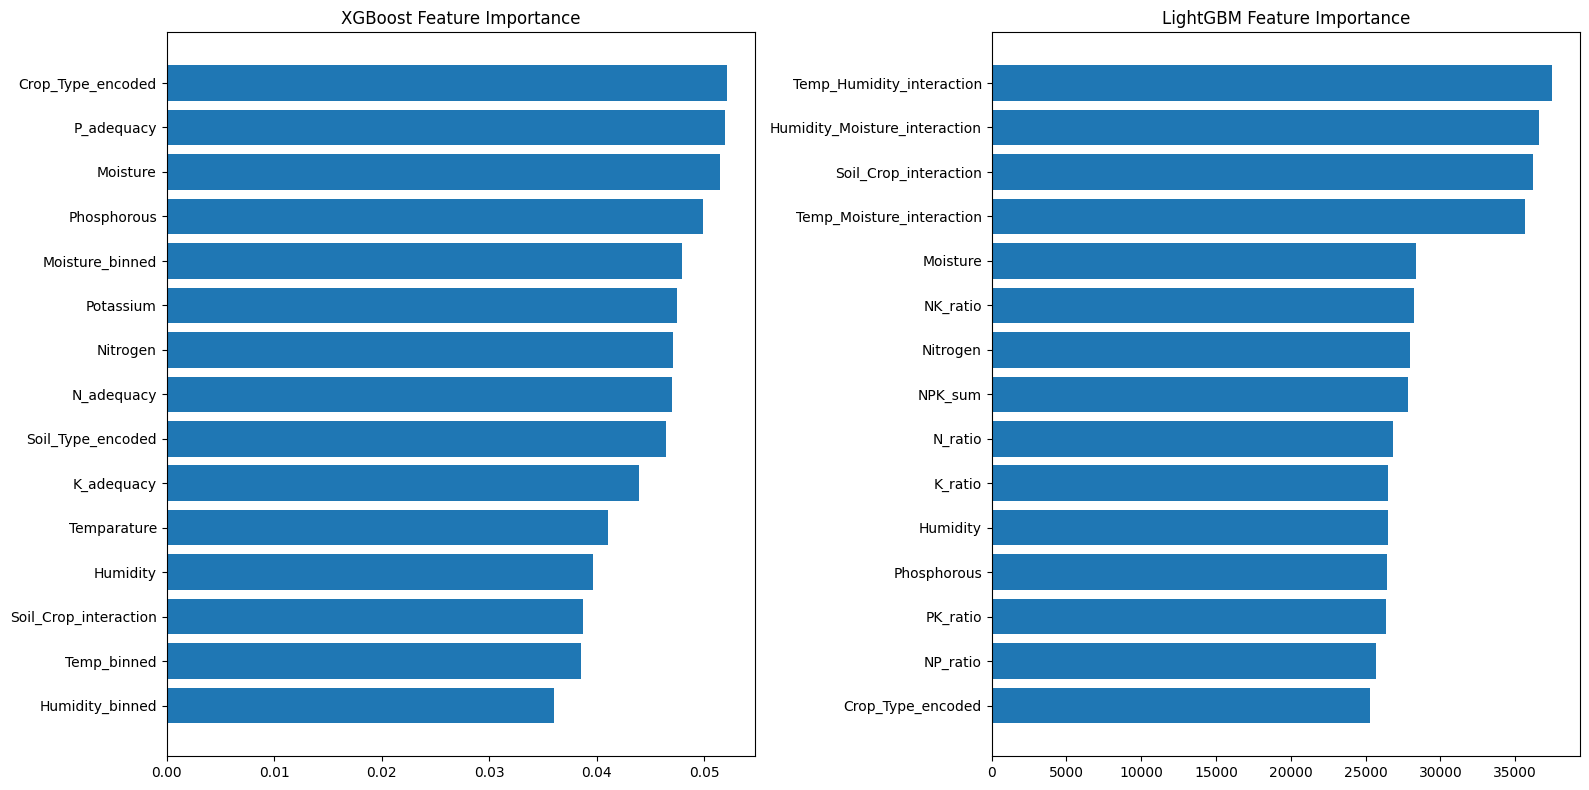

In [98]:
importance_df = pd.DataFrame({
'feature': feature_cols,
'xgb_importance': xgb_importance,
'lgb_importance': lgb_importance
})

importance_df['avg_importance'] = (importance_df['xgb_importance'] + importance_df['lgb_importance']) / 2
importance_df = importance_df.sort_values('avg_importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top_features_xgb = importance_df.nlargest(15, 'xgb_importance')
axes[0].barh(range(len(top_features_xgb)), top_features_xgb['xgb_importance'])
axes[0].set_yticks(range(len(top_features_xgb)))
axes[0].set_yticklabels(top_features_xgb['feature'])
axes[0].set_title('XGBoost Feature Importance')
axes[0].invert_yaxis()

top_features_lgb = importance_df.nlargest(15, 'lgb_importance')
axes[1].barh(range(len(top_features_lgb)), top_features_lgb['lgb_importance'])
axes[1].set_yticks(range(len(top_features_lgb)))
axes[1].set_yticklabels(top_features_lgb['feature'])
axes[1].set_title('LightGBM Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [99]:
importance_df[['feature', 'avg_importance']].head(10)

,feature,avg_importance
13,Temp_Humidity_interaction,18730.515189
15,Humidity_Moisture_interaction,18281.515283
21,Soil_Crop_interaction,18112.019351
14,Temp_Moisture_interaction,17820.515418
2,Moisture,14187.025718
11,NK_ratio,14106.017404
3,Nitrogen,13985.523540
6,NPK_sum,13913.015154
7,N_ratio,13408.015093
9,K_ratio,13253.515937
